# Part 1

In [1]:
# This cell consists a set of useful imports. Feel free to modify if you need anything else or would like
# remove a redundant import.

import numpy as np
from scipy.ndimage import gaussian_filter # This filter will be used to generate the smoothed model
import matplotlib.pyplot as plt

from devito import TimeFunction, Operator, Eq, solve, Function
from devito import norm, mmax, mmin
from examples.seismic import AcquisitionGeometry, Receiver
from examples.seismic.model import Model
from examples.seismic.acoustic import AcousticWaveSolver

# Reduce the level of output printed by Devito
from devito import configuration
configuration['log-level'] = 'WARNING'

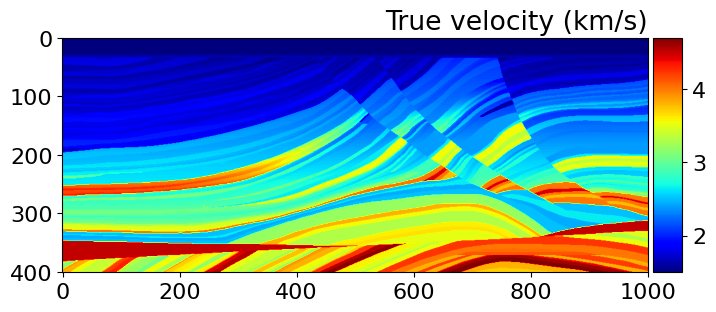

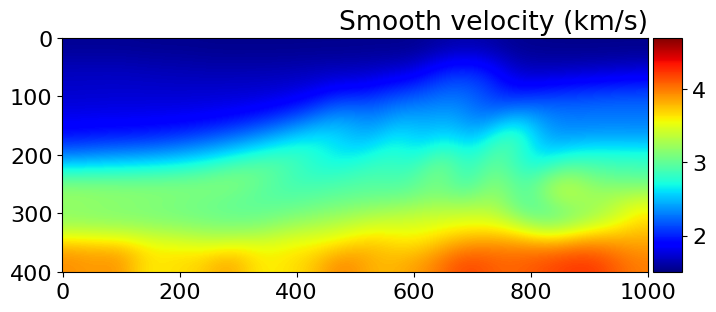

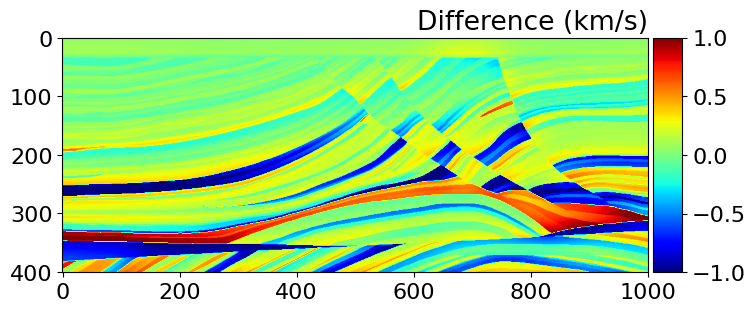

In [2]:
# Load 2D Marmousi velocity model from file
# Note that the data corresponds to the velocity of pressure waves in km/s
v = np.fromfile('data/vp_marmousi_bi', dtype='float32', sep="")

# Re-shape the velocity model v as required by the data
shape = (1601, 401)
spacing = (10., 10.) # physical grid dpacing, (dx, dy), in meters
origin = (0., 0.)
v = v.reshape(shape)

# Cut velocity model size from (1601,401) to (1001,401)
# (This is to speed up the computations a little)
v = v[300:-300, :]

# Gaussian smoothing of the true velocity model
# The 'smothed' version of our velocity model corresponds to something along the lines
# of what an initial guess may look like in a 'real' scenario
v_sm = gaussian_filter(v, sigma=(30, 30), order=0)

#Plot true & smooth Vp models, and their difference
from examples.seismic import plot_image
plt.title('True velocity (km/s)', loc='right')
plot_image(v, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Smooth velocity (km/s)', loc='right')
plot_image(v_sm, vmin=1.5, vmax=4.7, cmap="jet")
plt.title('Difference (km/s)', loc='right')
plot_image(v_sm-v, vmin=-1.0, vmax=1.0, cmap="jet")

## 1. [5 marks] Use the 'True' and 'smoothed' velocity profiles provided to create suitable Devito `Model` objects.

In [3]:
shape_adjusted = (1001, 401)
true_model = Model(vp=v, origin=origin, shape=shape_adjusted, spacing=spacing, space_order=2, nbl=60, bcs="damp")
smooth_model = Model(vp=v_sm, origin=origin, shape=shape_adjusted, spacing=spacing, space_order=2, nbl=60, bcs="damp")

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_velocity(model, source=None, receiver=None, colorbar=True, cmap="jet"):
    """
    Plot a two-dimensional velocity field from a seismic `Model`
    object. Optionally also includes point markers for sources and receivers.

    Parameters
    ----------
    model : Model
        Object that holds the velocity model.
    source : array_like or float
        Coordinates of the source point.
    receiver : array_like or float
        Coordinates of the receiver points.
    colorbar : bool
        Option to plot the colorbar.
    """
    domain_size = 1.e-3 * np.array(model.domain_size)
    extent = [model.origin[0], model.origin[0] + domain_size[0],
              model.origin[1] + domain_size[1], model.origin[1]]

    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    if getattr(model, 'vp', None) is not None:
        field = model.vp.data[slices]
    else:
        field = model.lam.data[slices]
    plot = plt.imshow(np.transpose(field), animated=True, cmap=cmap,
                      vmin=np.min(field), vmax=np.max(field),
                      extent=extent)
    plt.xlabel('X position (km)')
    plt.ylabel('Depth (km)')

    # Plot source points, if provided
    if receiver is not None:
        plt.scatter(1e-3*receiver[:, 0], 1e-3*receiver[:, 1],
                    s=25, c='green', marker='D')

    # Plot receiver points, if provided
    if source is not None:
        plt.scatter(1e-3*source[:, 0], 1e-3*source[:, 1],
                    s=25, c='red', marker='o')

    # Ensure axis limits
    plt.xlim(model.origin[0], model.origin[0] + domain_size[0])
    plt.ylim(model.origin[1] + domain_size[1], model.origin[1])

    # Create aligned colorbar on the right
    if colorbar:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label('Velocity (km/s)')
    plt.show()

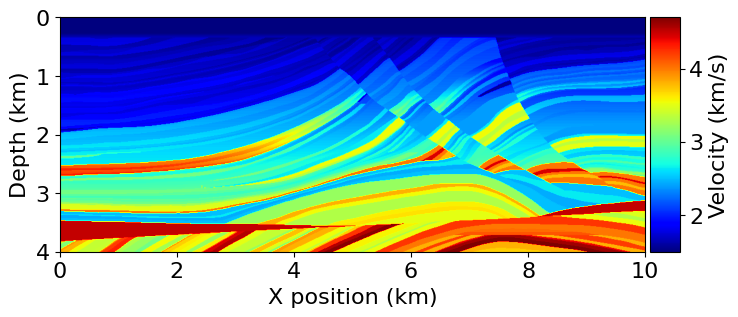

In [5]:
plot_velocity(true_model)

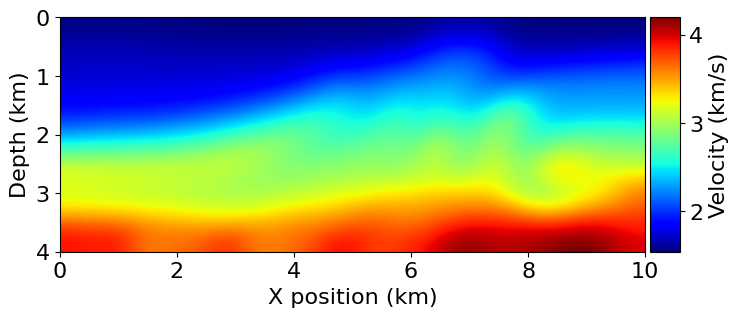

In [6]:
plot_velocity(smooth_model)

## 2. [10 marks] Devise and plot an aquisition geometry for the domain. That is:

### 2.1 Choose a suitable start time, end time and Ricker source peak frequency.

In [7]:
from examples.seismic import RickerSource, Receiver, TimeAxis
t0 = 0.
tn = 8000.
dt = true_model.critical_dt

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.003 


### 2.2 Create a set of 3 Ricker sources.

In [8]:
nsrc = 3
src_coordinates = np.empty((nsrc, 2))
src_coordinates[:, 0] = np.linspace(0, true_model.domain_size[0], num=nsrc)
src_coordinates[:, 1] = 20.0

src = RickerSource(name='src', grid=true_model.grid, f0=f0, npoint=nsrc, time_range=time_range)
src.coordinates.data[:] = src_coordinates

### 2.3 Create a set of receivers.

In [9]:
nrec = 201
rec_coordinates = np.empty((nrec, 2))
rec_coordinates[:, 0] = np.linspace(0, true_model.domain_size[0], num=nrec)
rec_coordinates[:, 1] = 20.0

rec = Receiver(name='rec', grid=true_model.grid, npoint=nrec, time_range=time_range)
rec.coordinates.data[:] = rec_coordinates

### 2.4 Plot an aquisition geometry

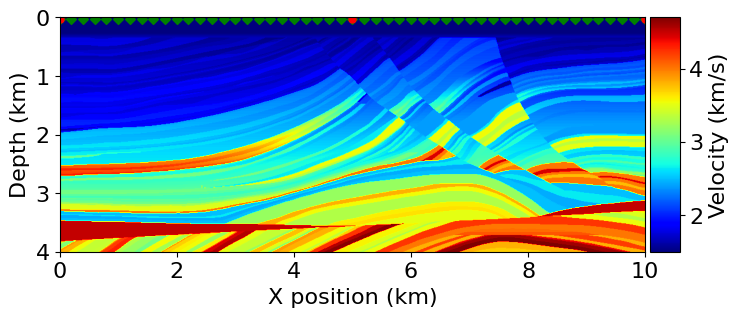

In [10]:
plot_velocity(true_model, source=src_coordinates, receiver=rec_coordinates[::4]);

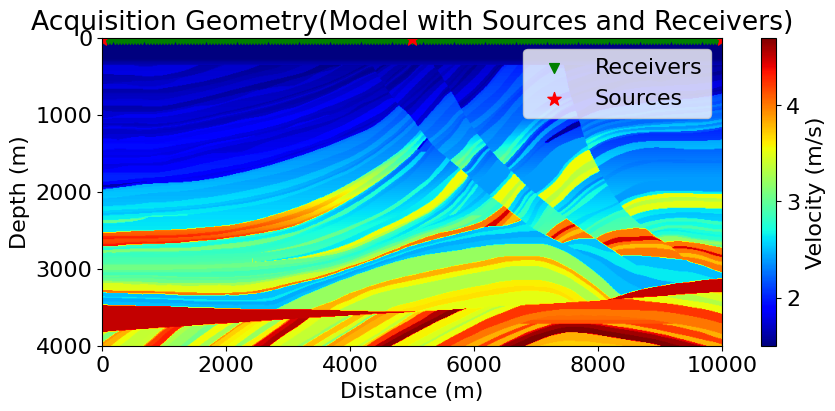

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(v.transpose(), cmap="jet", origin='upper', aspect='auto',
           extent=[0, true_model.domain_size[0], true_model.domain_size[1], 0])
plt.colorbar(label='Velocity (m/s)')

plt.scatter(rec_coordinates[:, 0], rec_coordinates[:, 1], color='green', marker='v', s=50, label='Receivers')
plt.scatter(src_coordinates[:, 0], src_coordinates[:, 1], color='red', marker='*', s=100, label='Sources')

plt.xlabel('Distance (m)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('Acquisition Geometry(Model with Sources and Receivers)')
plt.show()


## 3. [10 marks] For both the 'True' and 'Smooth' models and for each source location execute forward simulations and plot the shot records and their differences. (For each source location three plots should be generated, and hence nine in total for this section).

First draw three geometries for three different sources.

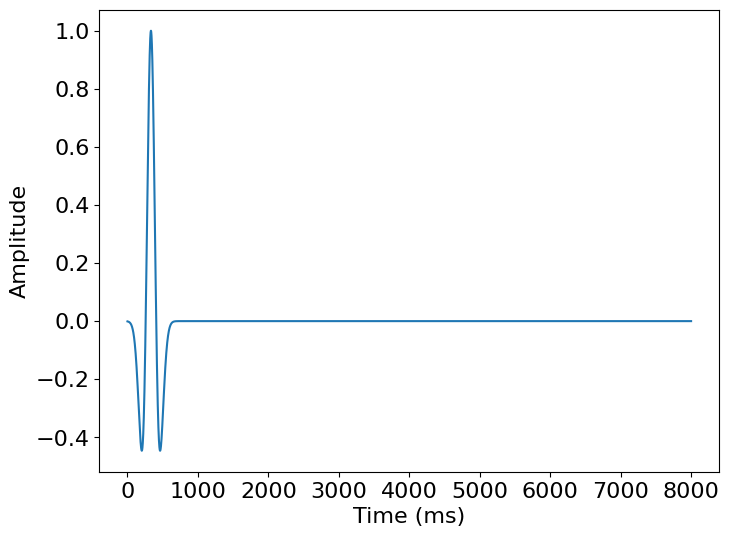

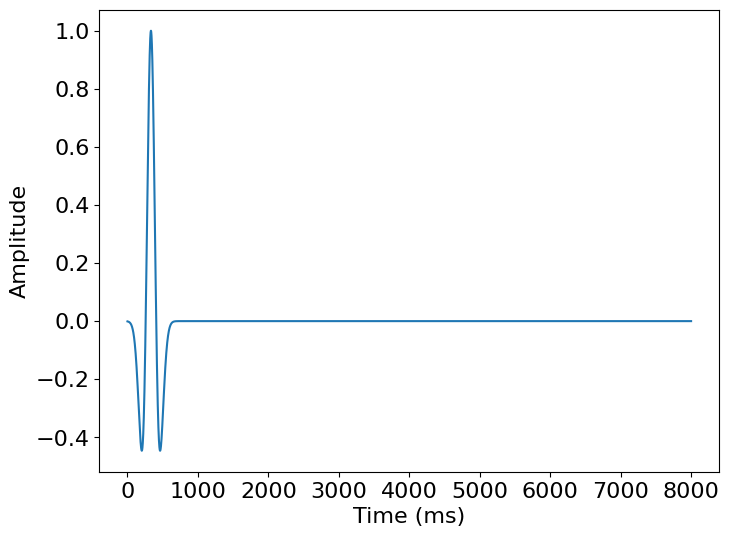

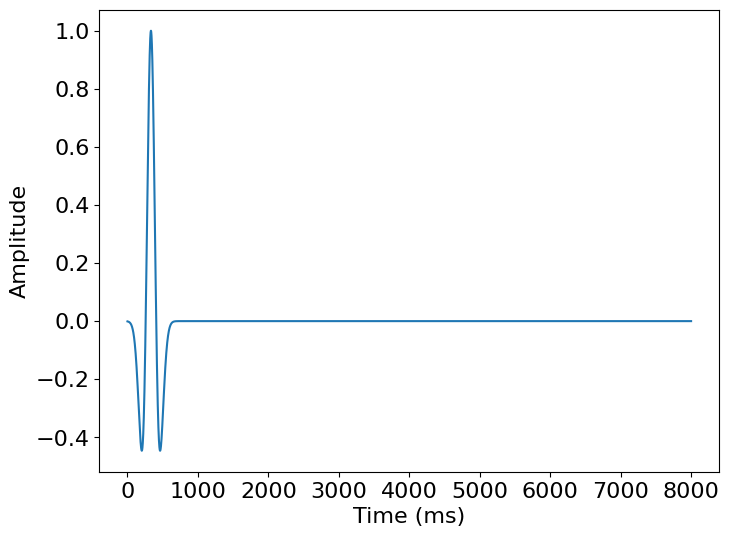

In [12]:
for i in range(3):
    geometry = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates[0], t0, tn, f0=f0, src_type='Ricker')
    geometry.src.show()


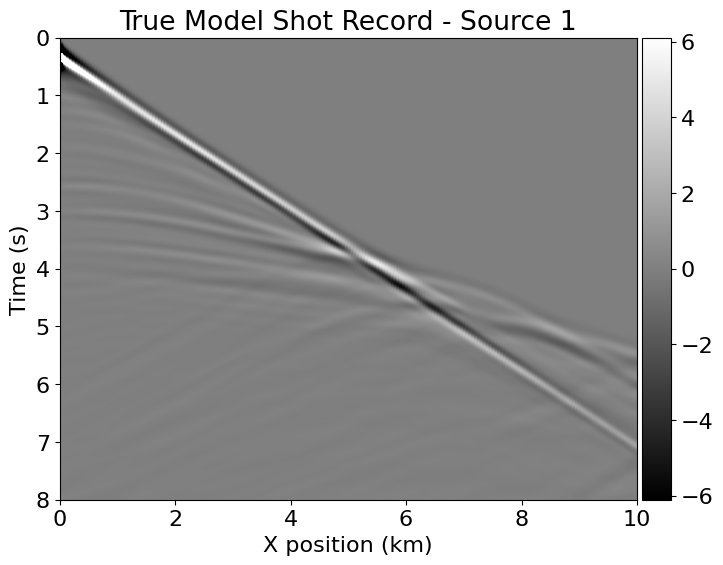

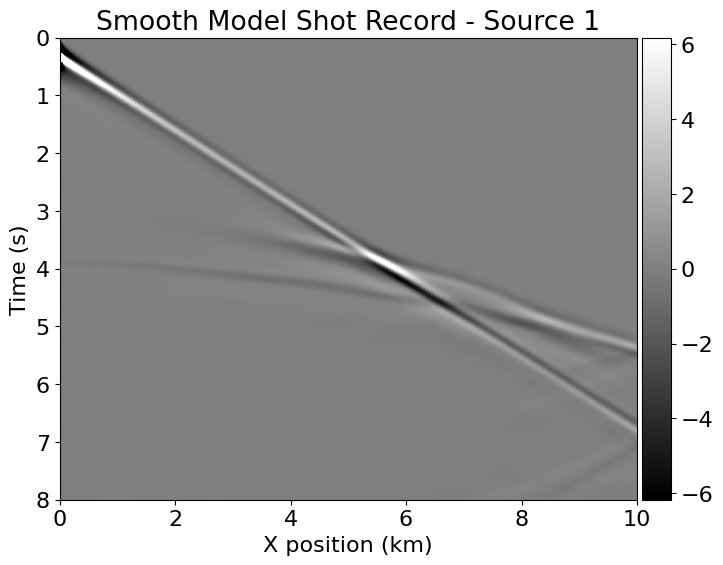

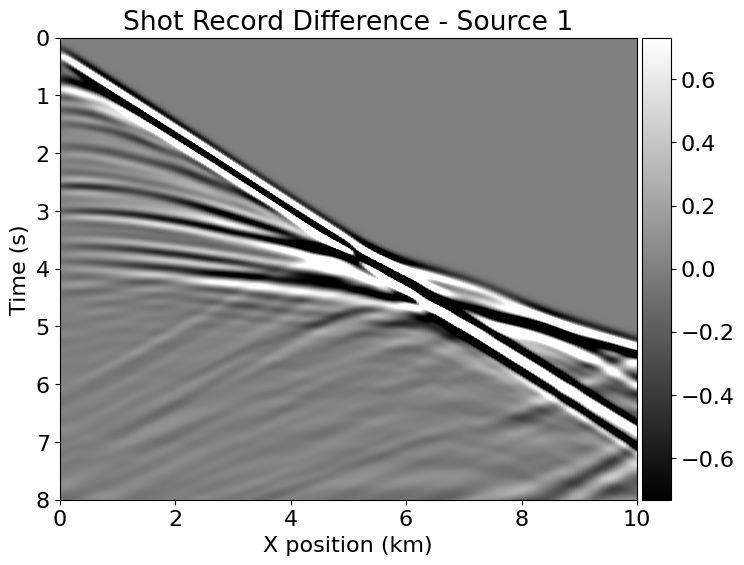

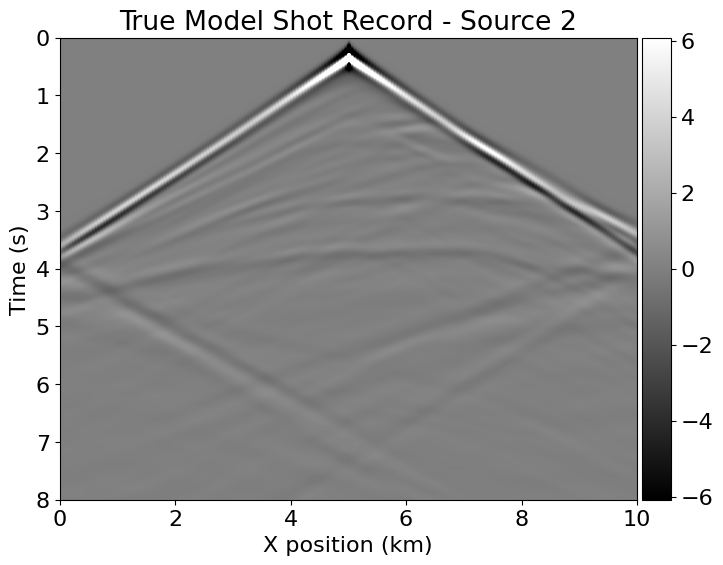

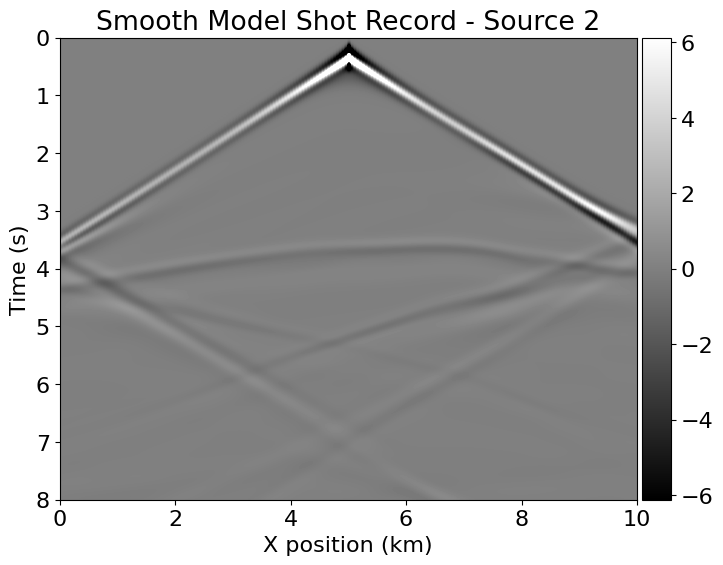

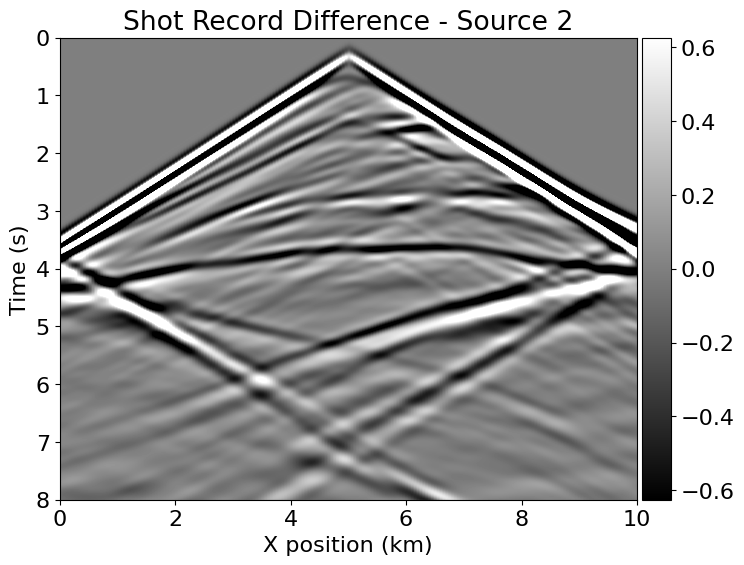

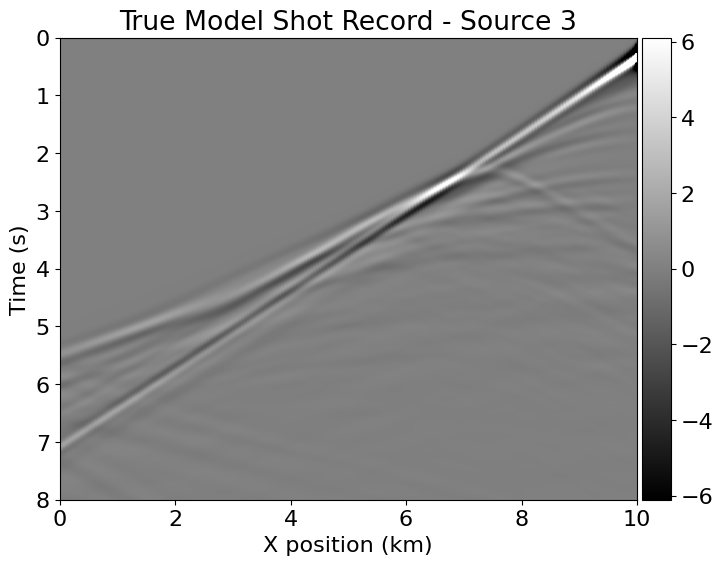

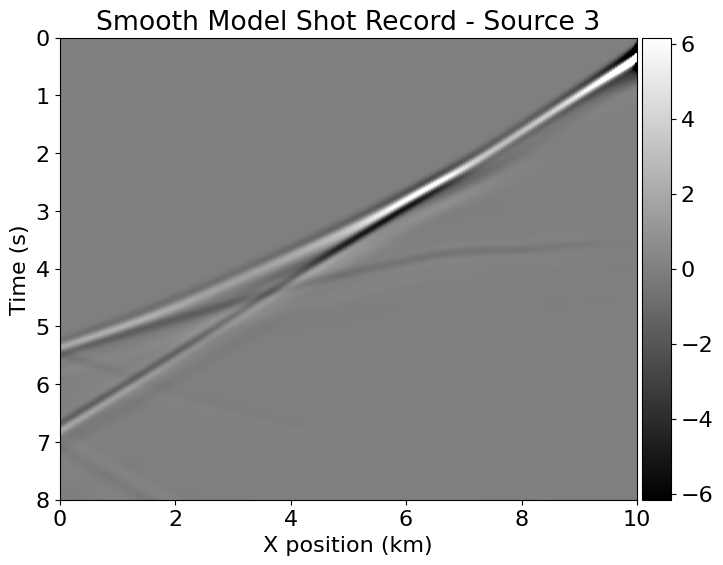

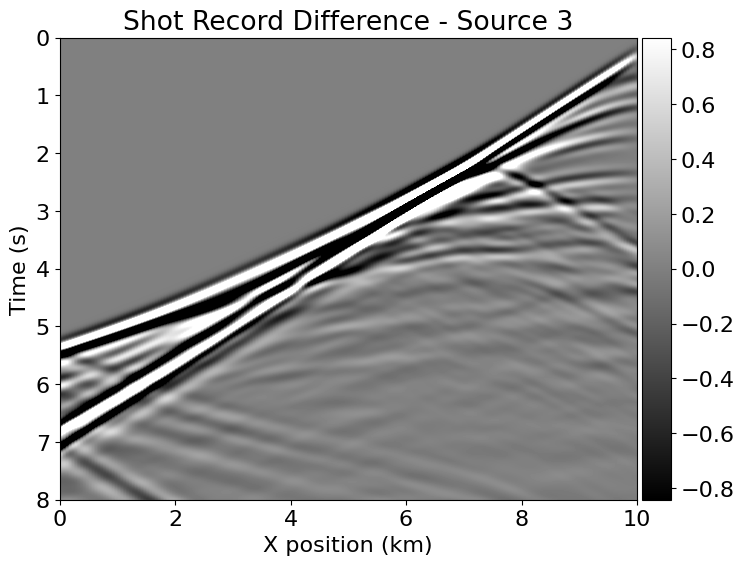

In [13]:
from examples.seismic import plot_shotrecord

for i in range(nsrc):
    geometry = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates[i], t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(true_model, geometry, space_order=4)
    true_d, _, _ = solver.forward(vp=true_model.vp)
    smooth_d, _, _ = solver.forward(vp=smooth_model.vp)

    plt.title(f'True Model Shot Record - Source {i+1}')
    plot_shotrecord(true_d.data, true_model, t0, tn)
    
    plt.title(f'Smooth Model Shot Record - Source {i+1}')
    plot_shotrecord(smooth_d.data, true_model, t0, tn)
    
    plt.title(f'Shot Record Difference - Source {i+1}')
    plot_shotrecord(smooth_d.data - true_d.data, true_model, t0, tn)

## 4. [15 marks] Discuss and justify the choices made in parts 2 and 3

As the begining of the part, let's encapsulate all the functions above so that we can use them easily for the result analysis.

We are going to use the middle source as the default source to do discussion and justify for this part, along with default tn=4000, f0=0.01, nbl=60.

In [14]:
def simple_model(t0=0., tn=8000., f0=0.003, nbl=60, source=1):
    shape_adjusted = (1001, 401)
    true_model = Model(vp=v, origin=origin, shape=shape_adjusted, spacing=spacing, space_order=2, nbl=nbl, bcs="damp")
    smooth_model = Model(vp=v_sm, origin=origin, shape=shape_adjusted, spacing=spacing, space_order=2, nbl=nbl, bcs="damp")

    dt = true_model.critical_dt
    time_range = TimeAxis(start=t0, stop=tn, step=dt)

    nsrc = 3
    src_coordinates = np.empty((nsrc, 2))
    src_coordinates[:, 0] = np.linspace(0, true_model.domain_size[0], num=nsrc)
    src_coordinates[:, 1] = 20.0

    src = RickerSource(name='src', grid=true_model.grid, f0=f0, npoint=nsrc, time_range=time_range)
    src.coordinates.data[:] = src_coordinates

    nrec = 201
    rec_coordinates = np.empty((nrec, 2))
    rec_coordinates[:, 0] = np.linspace(0, true_model.domain_size[0], num=nrec)
    rec_coordinates[:, 1] = 20.0

    rec = Receiver(name='rec', grid=true_model.grid, npoint=nrec, time_range=time_range)
    rec.coordinates.data[:] = rec_coordinates

    geometry = AcquisitionGeometry(true_model, rec_coordinates, src_coordinates[source], t0, tn, f0=f0, src_type='Ricker')
    solver = AcousticWaveSolver(true_model, geometry, space_order=4)
    true_d, _, _ = solver.forward(vp=true_model.vp)
    smooth_d, _, _ = solver.forward(vp=smooth_model.vp)

    plt.title(f'True Model Shot Record - nbl={nbl}, tn={tn}, f0={f0}')
    plot_shotrecord(true_d.data, true_model, t0, tn)

    plt.title(f'Smooth Model Shot Record - nbl={nbl}, tn={tn}, f0={f0}')
    plot_shotrecord(smooth_d.data, true_model, t0, tn)

    plt.title(f'Shot Record Difference - nbl={nbl}, tn={tn}, f0={f0}')
    plot_shotrecord(smooth_d.data - true_d.data, true_model, t0, tn)

### 4.1 Explain your choice regarding the number of boundary layers when creating the models.

In the model we create in this notebook, we use __60 as the number of boundary layers__.

#### Discussion



In my solution above, I will simply use the situation that the position of source in the middle with all the 201 receivers to analyse the use of number of boundary layers.

To start with, let's explain what is the number of boundary layers. 

When creating the model, the number of boundary layers is selected to absorb the wave energy at the boundary, which is helpful to avoid non-physical reflections in the simulation results and reduce the reflection impact of the calculation boundary on the wave field simulation. Boundary layers simulate an infinite medium by absorbing wave energy reaching the boundary. 

A small number of boundary layers is not enough to absorb the wave energy at the boundary and a large number of boundary layers means greater computational cost. In this case, the choice of the number of boundary layers should balances the need for computational efficiency with the minimization of boundary reflections.

#### Justification

In the model we create in this notebook, we use 60 as the number of boundary layers.
To justify this, let's first have a look about the shot record with different number of boundary layers:


First, let's have a look what will happen if we choose a quite small nbl, where nbl = 1.

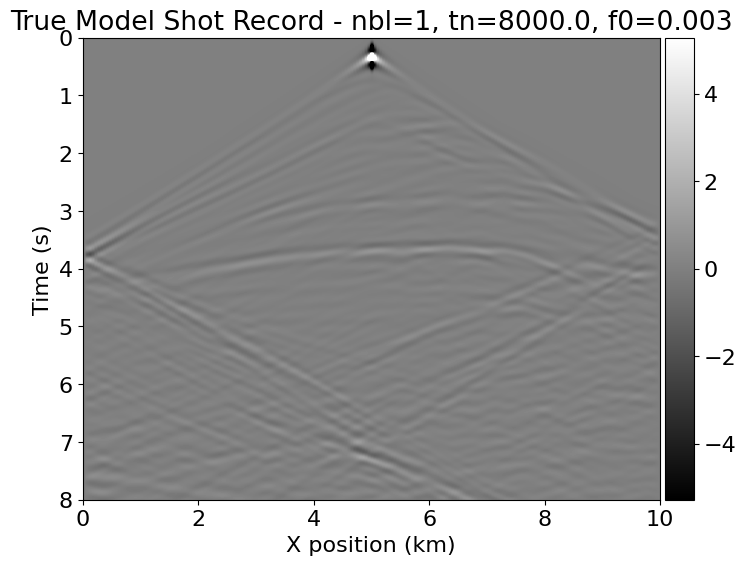

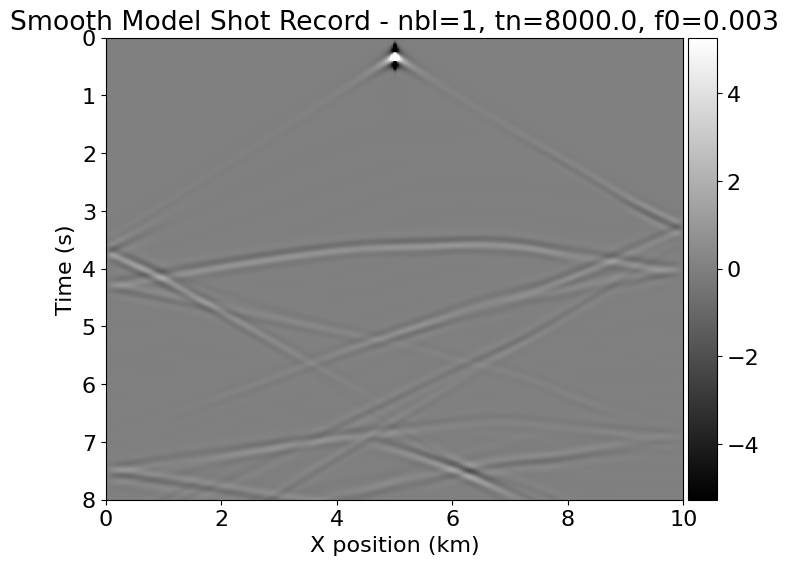

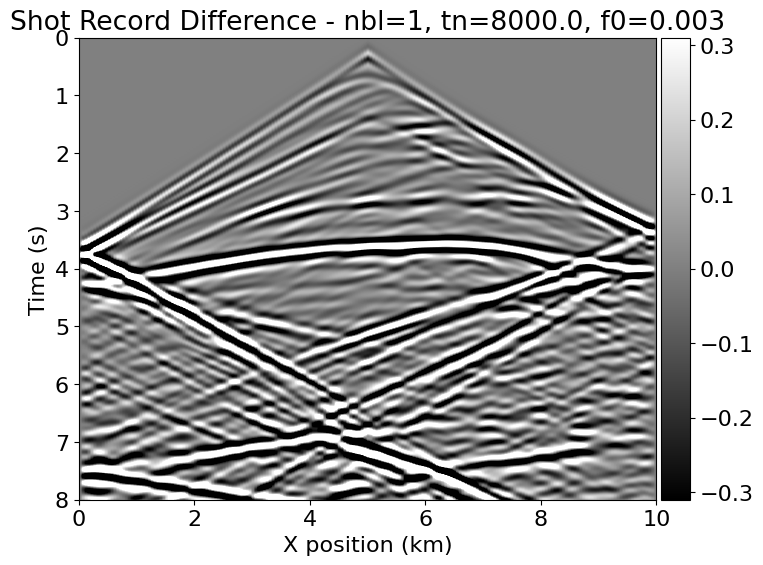

In [22]:
simple_model(nbl=1)

Then, we increase the number of boundary layers to 10.

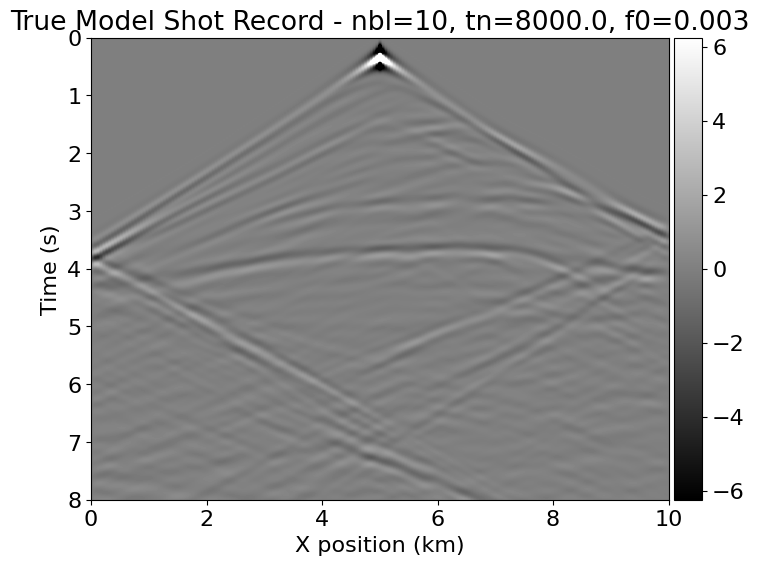

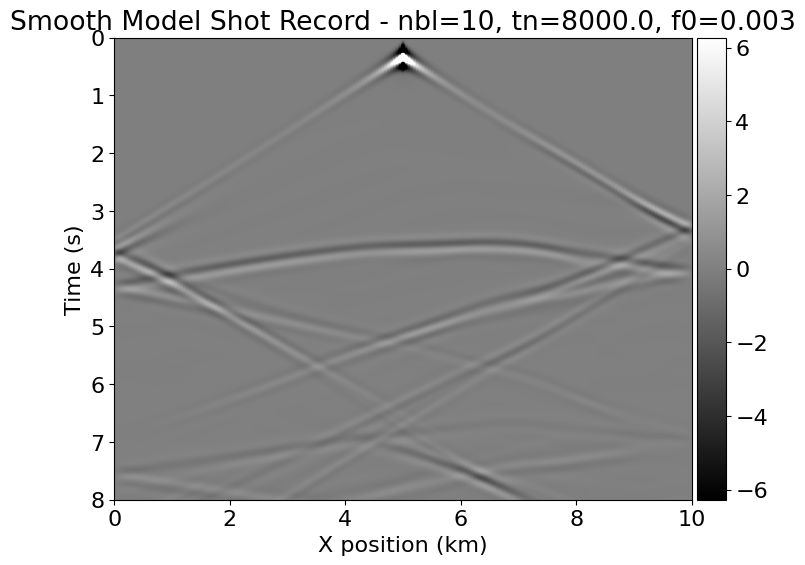

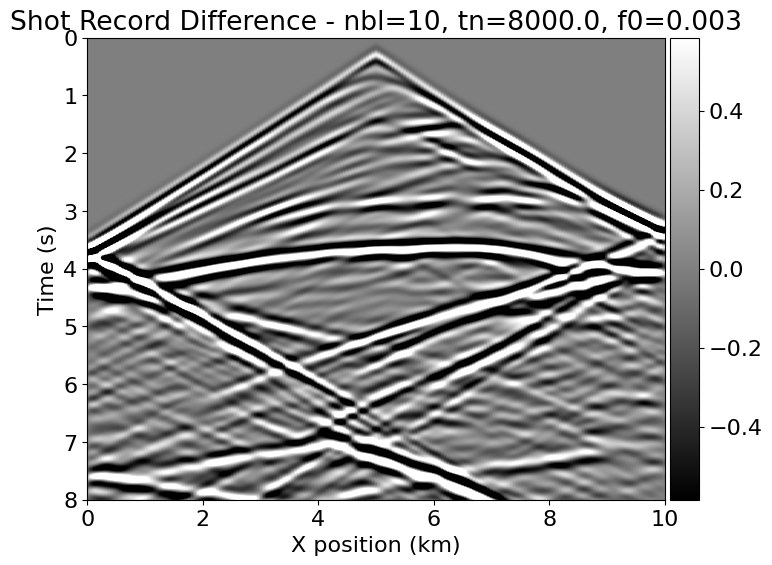

In [16]:
simple_model(nbl=10)

Then, increase the number of boundary layers to 20.

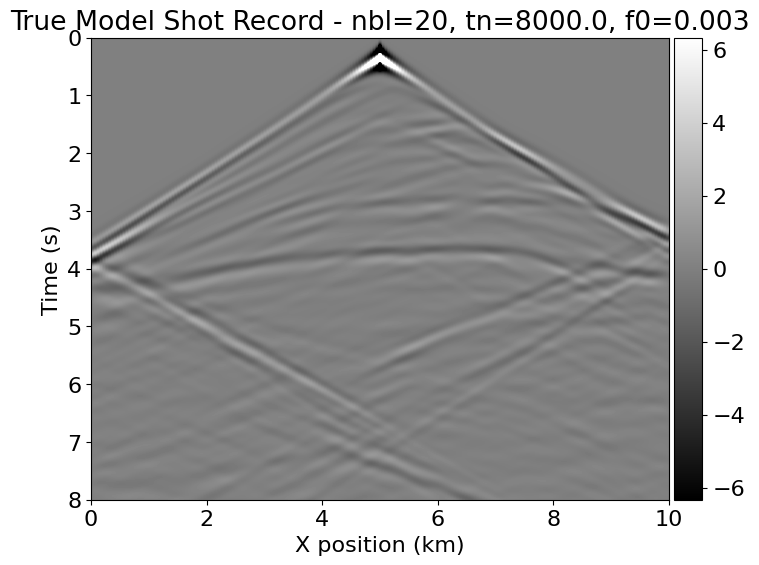

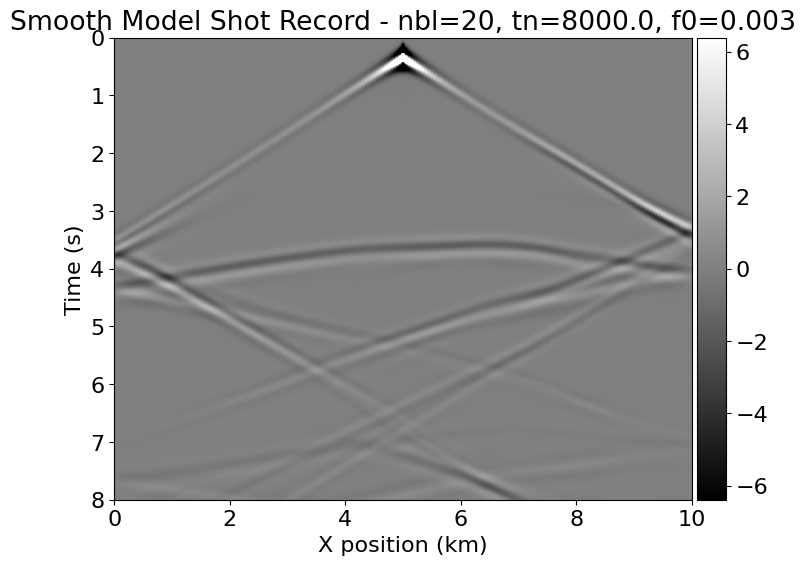

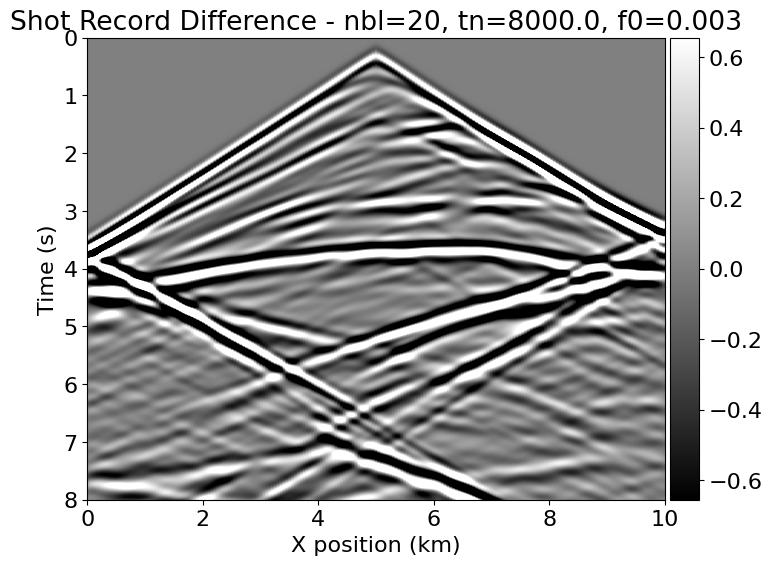

In [17]:
simple_model(nbl=20)

Then, increase the number of boundary layers to 40.

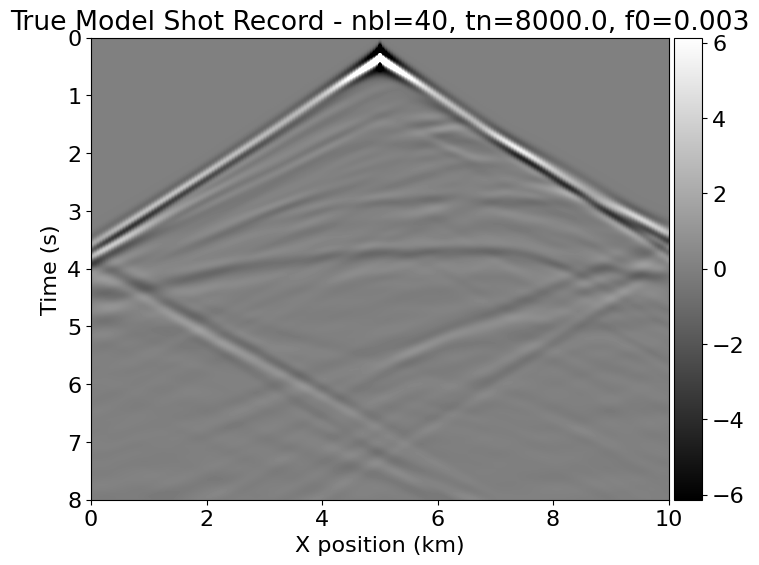

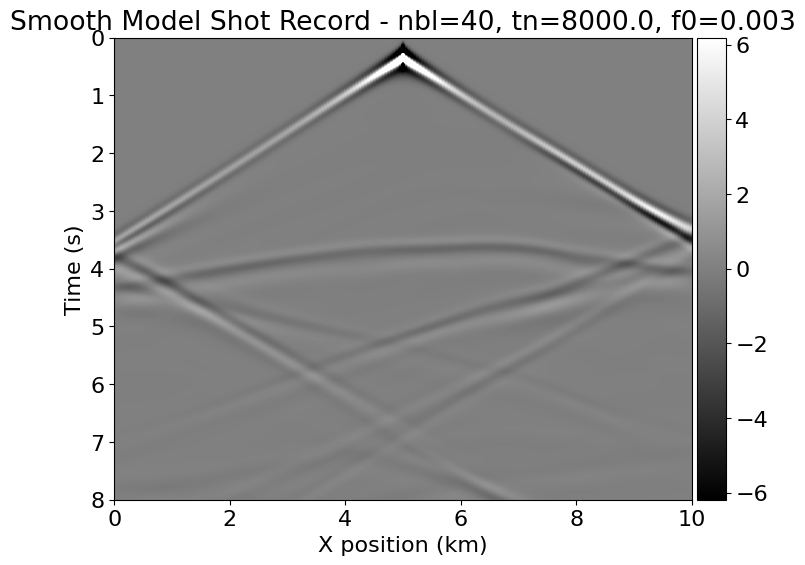

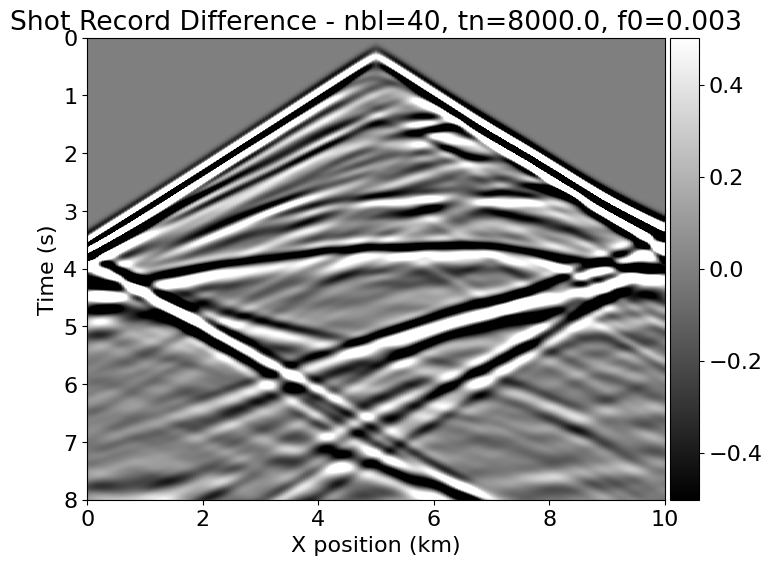

In [23]:
simple_model(nbl=40)

Then, let's increase the number of boundary layers to 60.

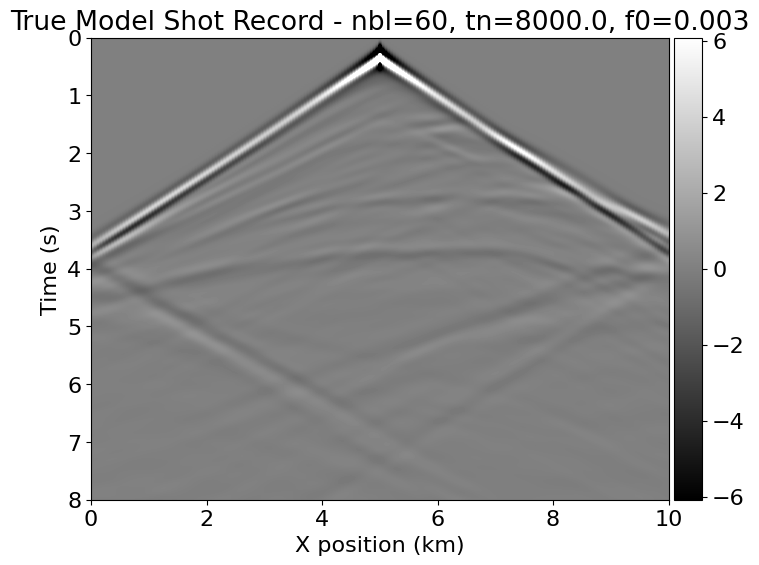

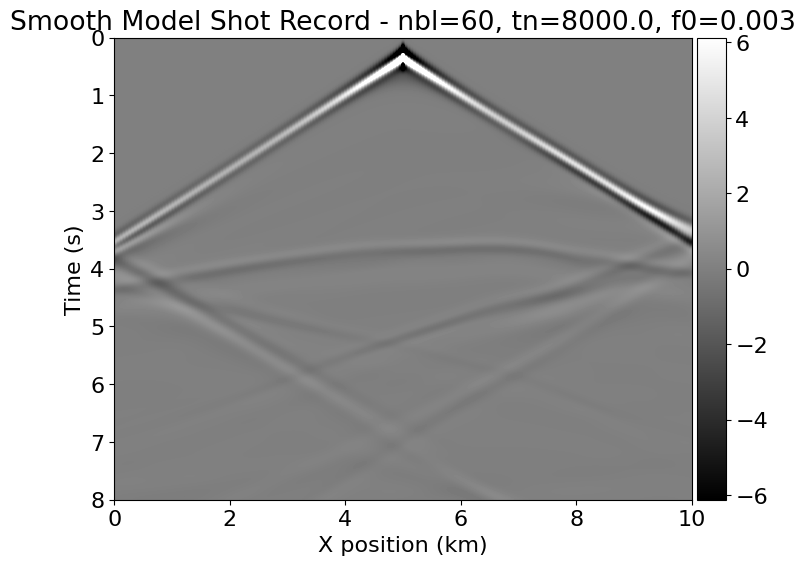

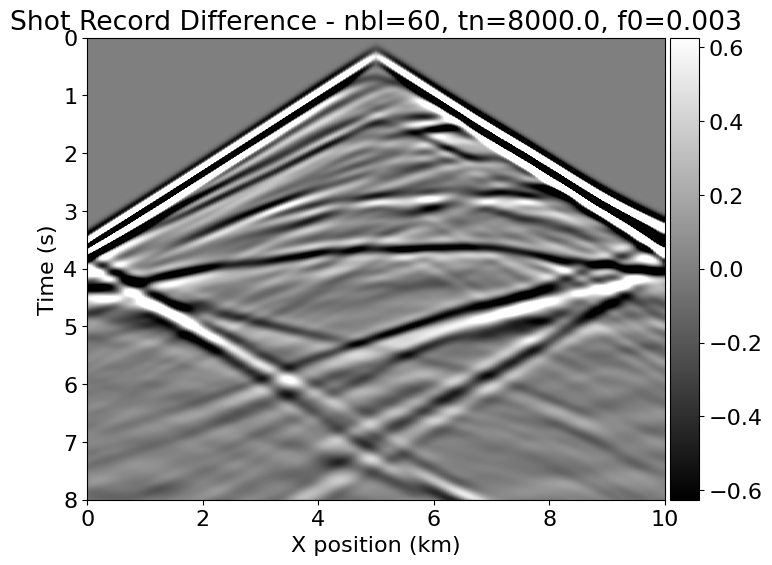

In [19]:
simple_model(nbl=60)

Then, let's increase the number of boundary layers to 80.

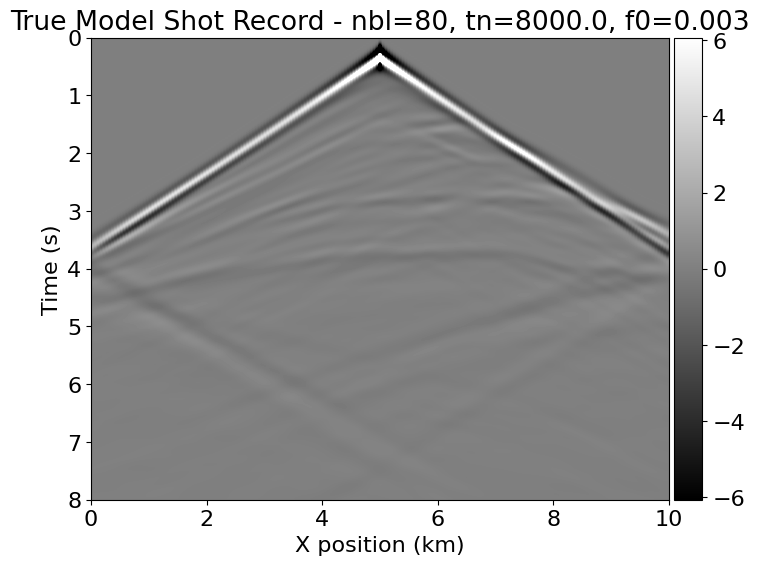

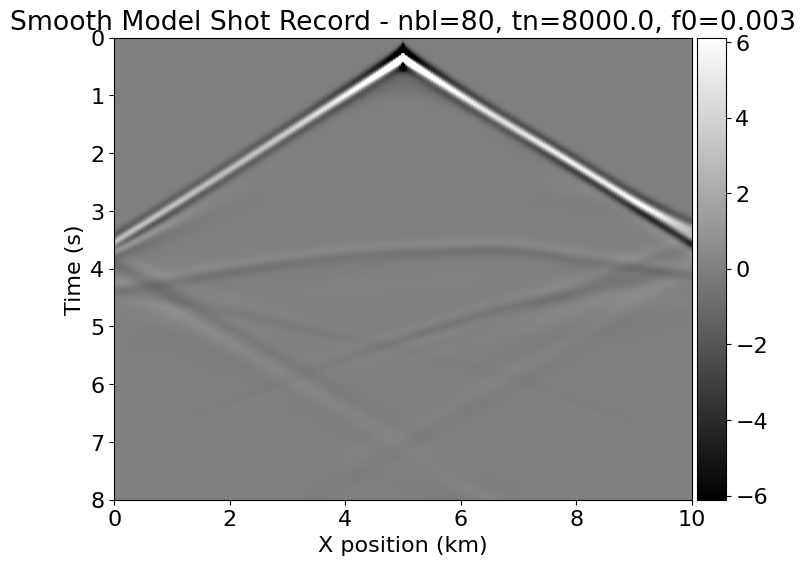

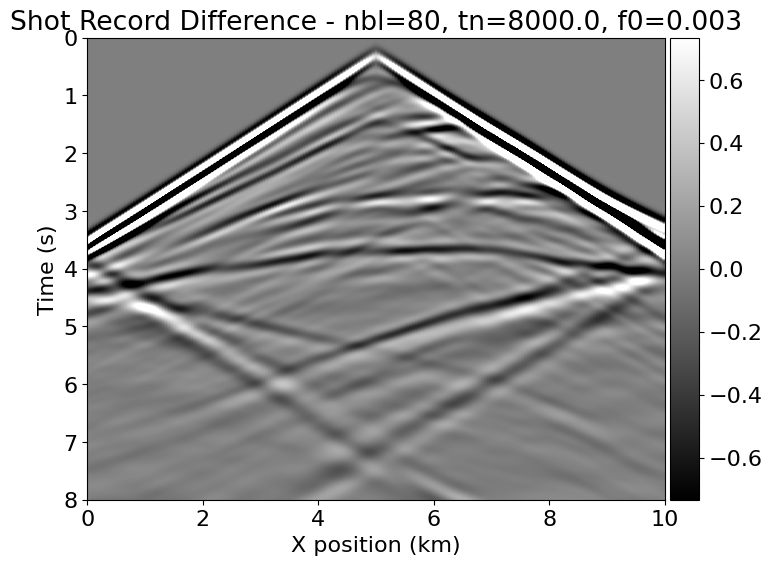

In [20]:
simple_model(nbl=80)

Then, let's increase the number of boundary layers to 100.

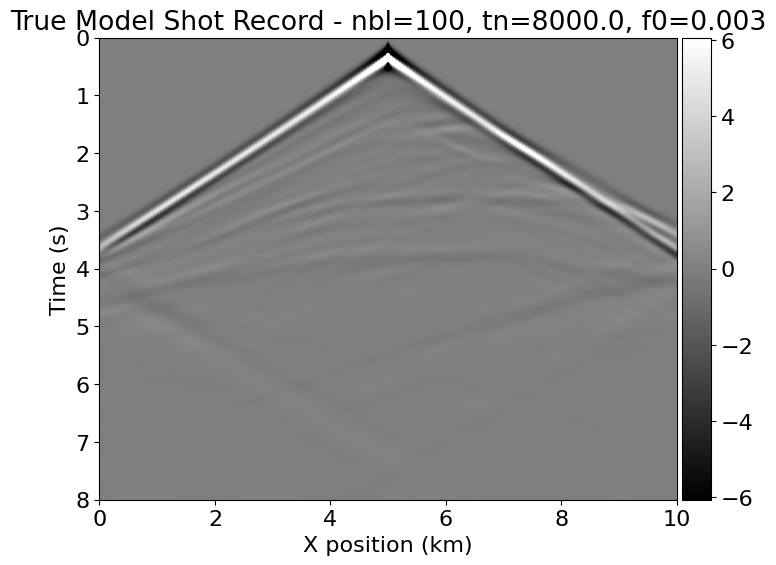

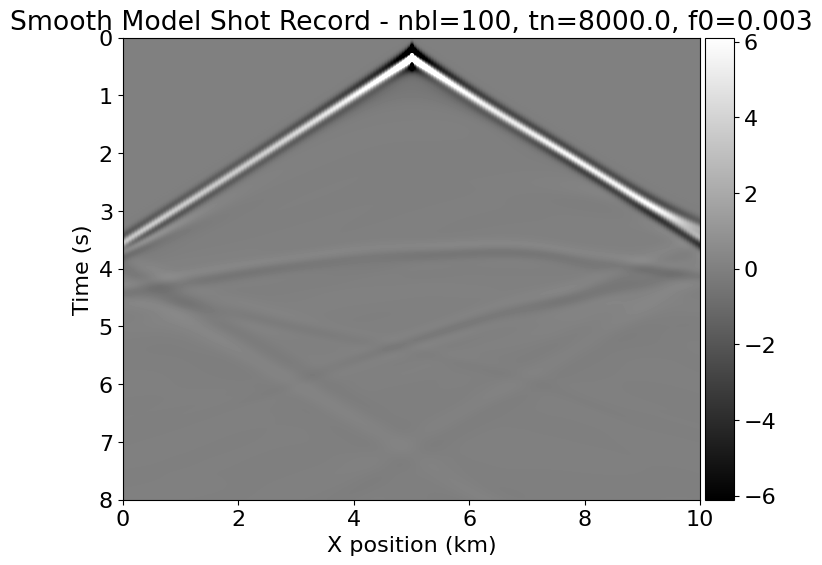

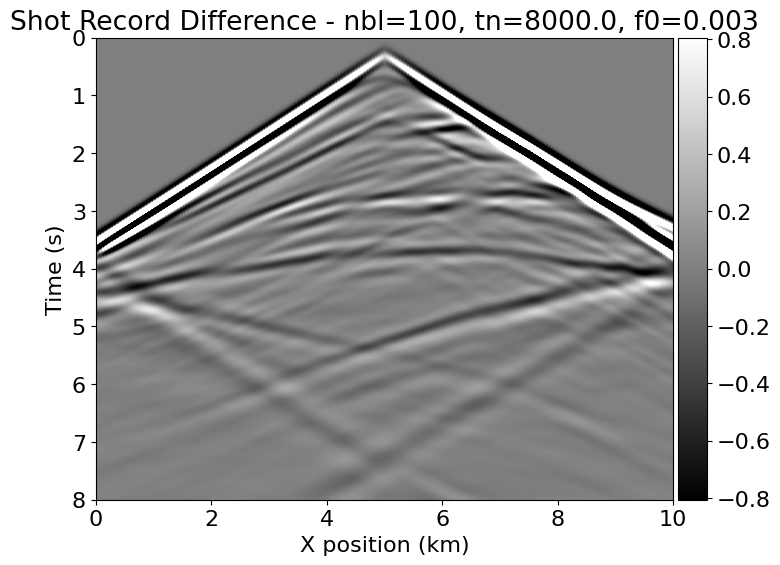

In [21]:
simple_model(nbl=100)

From the experiment above: 

1. When nbl=1, we can see there is quite big impact of the reflection in the boundary. The impact reflection is shown in the bottom, bottom left, and bottom right in the form of wave in the Shot Record image.
2. With the increase of nbl, we can see that the impact of the reflection in the boundary become fewer and fewer. When it reaches 100, there is no obvious reflection.
3. With the increase of nbl, we can see that the computational cost increase. Although we do not use _timeit_ to measure the accuracy time cost, we can see this according to the execution time of each python cell:

<div align="center">

|    nbl   |   Time Cost   |
|----------|----------|
|      1   |    4.9   |
|     10   |    5.2   |
|     20   |    5.6   |
|     40   |    5.8   |
|     60   |    6.3   |
|     80   |    7.7   |
|    100   |    8.4   |

</div>

4. As a result, we consider that the choice of the number of boundary layers should balance the need for computational efficiency with the minimization of boundary reflections. In the middle value of nbl that we use above which is 60, the reflection is highly decreased compared to a lower number of nbl. And is has lower computation cost when compared to a higher value of nbl. Then, 60 is chosen as the nbl value that we use in model to create in this project. It balances the computational efficiency and the boundary reflections.



### 4.2 Explain your choices regarding the end time of the simulation and the Ricker source peak frequency.

In the model we create in this notebook, we use __8s as the end time of the simulation__ and __3Hz as the Ricker source peak frequency__.

#### Discussion - End Time

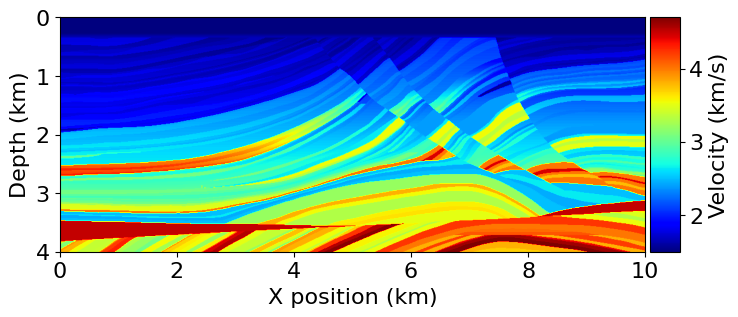

In [24]:
plot_velocity(true_model)

When considering end time, the main factor is the time required for seismic waves to propagate in the model, which depends on the velocity structure of the geological model and the depth of detection.

From the true velocity, we can see that the velocity is changing around the interval [2km/s, 4km/s]. Then we get:

\begin{equation}
v_{min} = 2km/s = 2000m/s
\tag{1}
\end{equation}

To calculate tn, we can use the longest time it takes for a seismic wave to travel to the deepest depth (4000 meters in our project situation) and back at the lowest speed in the model. Then we use the following formula to calculate:

\begin{equation}
tn = \frac{2*deepest\_depth}{v_{min}} = \frac{2*4000m}{2000m/s} = 4s
\tag{2}
\end{equation}

Then we get the theoretical minimum tn for this situation.

Apart from this, there are more things that we need consider that we need add more time to tn:

_Reflection and refraction_: Waves will be reflected and refracted when they encounter interfaces with large velocity changes, which may cause the propagation path to become longer.

_Different types of waves_: P waves and S waves have different speeds. S waves are slower than P waves, so they may take longer.

_Stability and accuracy of numerical simulation_: In order to ensure that the waveform will not be truncated due to the sudden end of the simulation, some buffer time is usually added to the calculated tn.

Taking these factors into account, the end time tn is set around 6 seconds to ensure a sufficient time window to observe all wave propagation effects of interest.

#### Justification - End Time

First let's try tn = 6000ms to see the result.

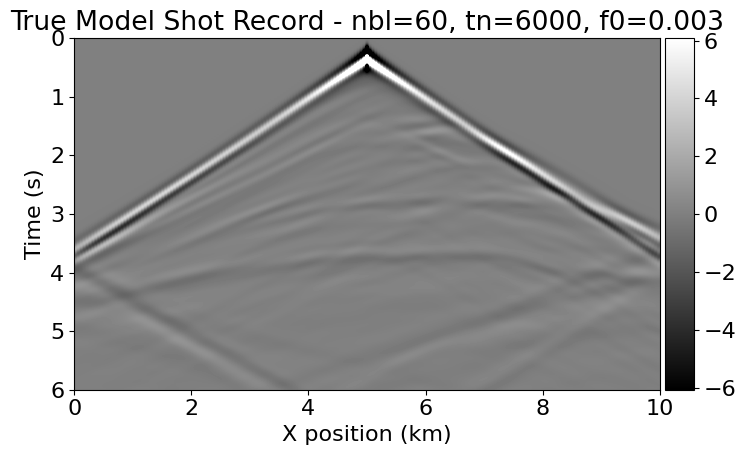

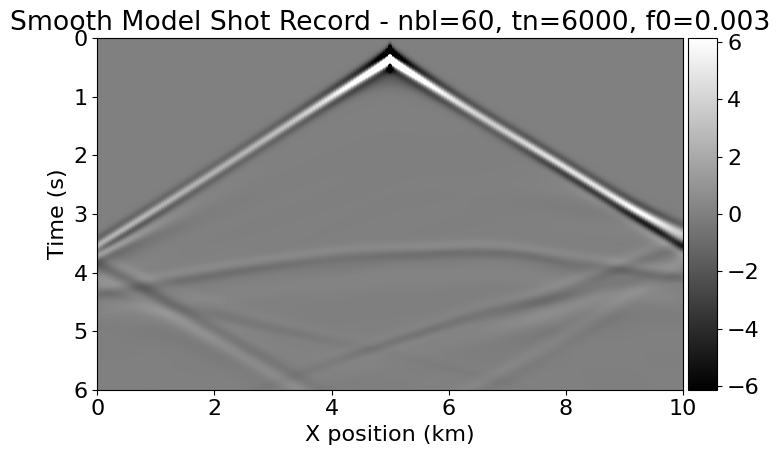

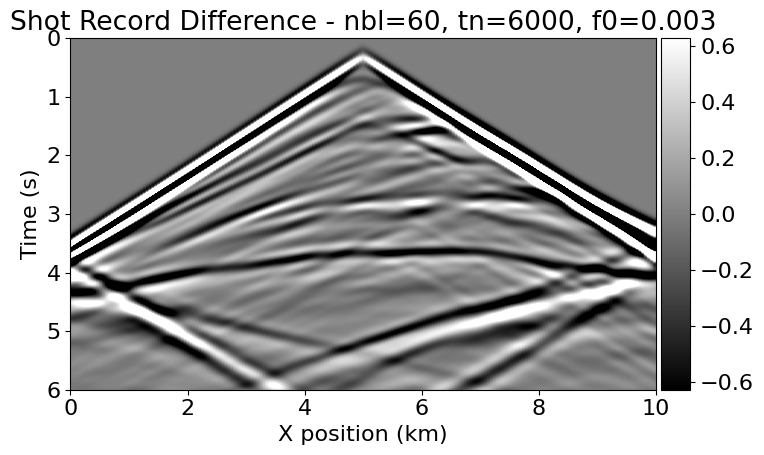

In [25]:
simple_model(tn=6000)

As mentioned at the beginning of thie part(4), the default source we use is the middle one. Recall that we have three source, one in the most left of the top, one in the middle and one in the most right. If we use the one in the most left or most right, it would cost more time to reach another boundary. Let's try the source in the most left with tn=6000ms:

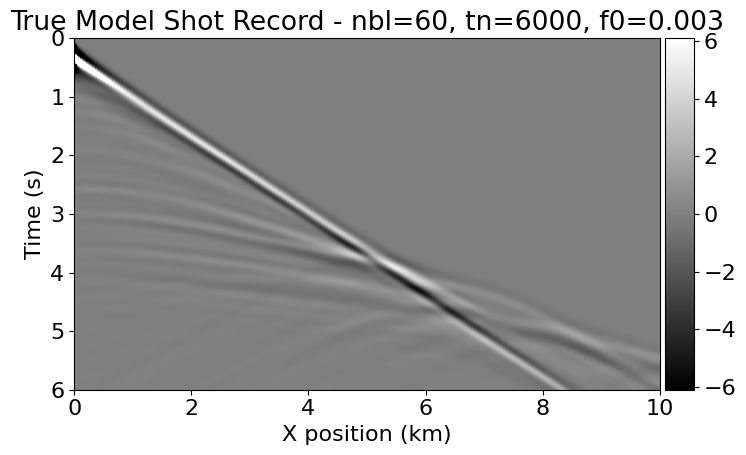

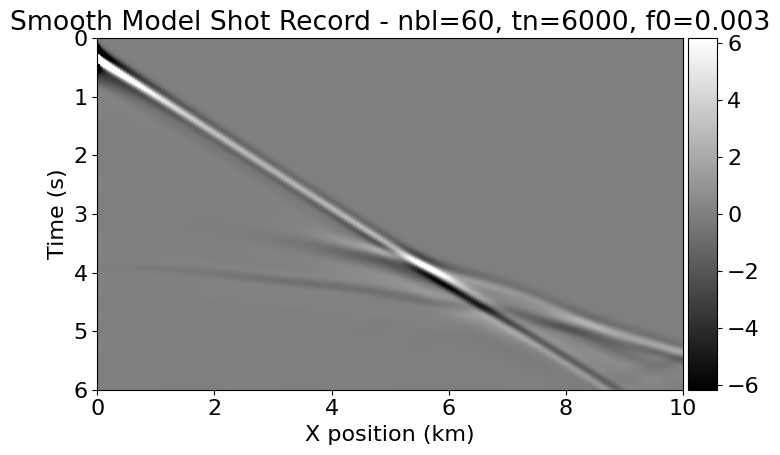

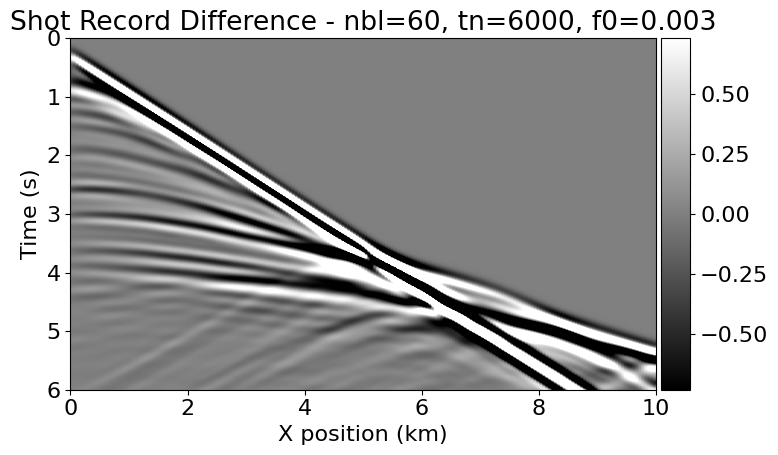

In [26]:
simple_model(tn=6000, source=0)

It seems we need more time for the wave to broadcast。

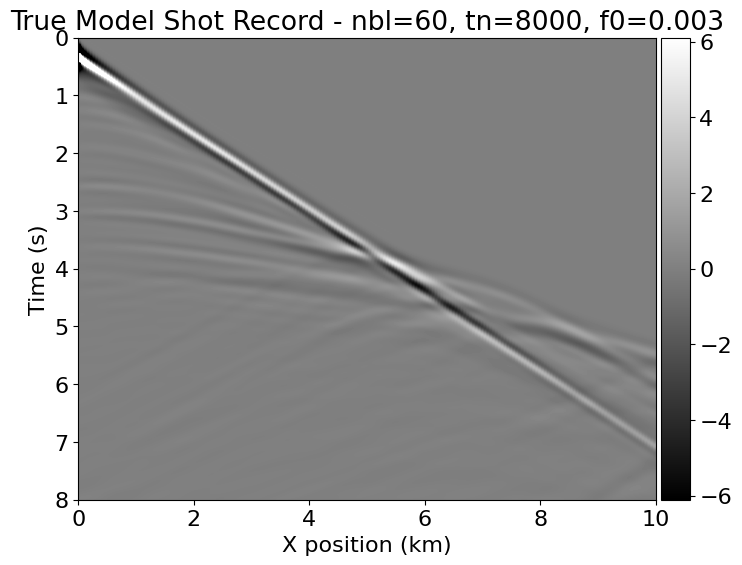

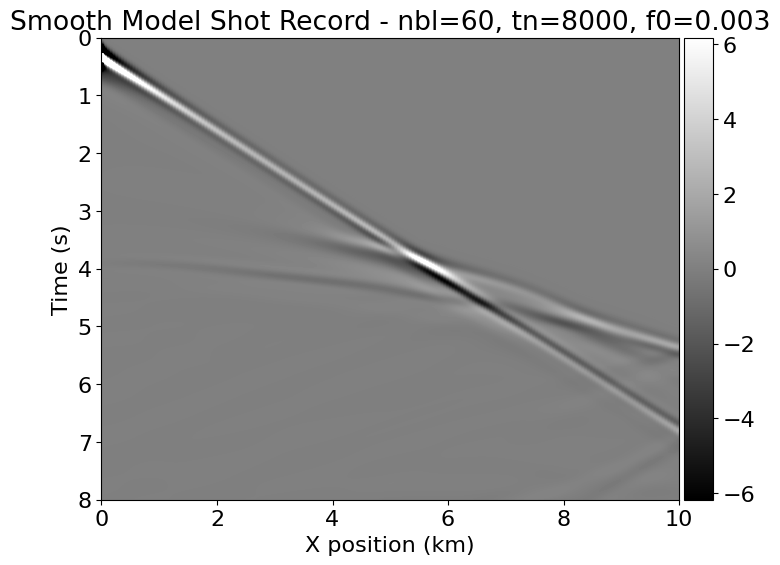

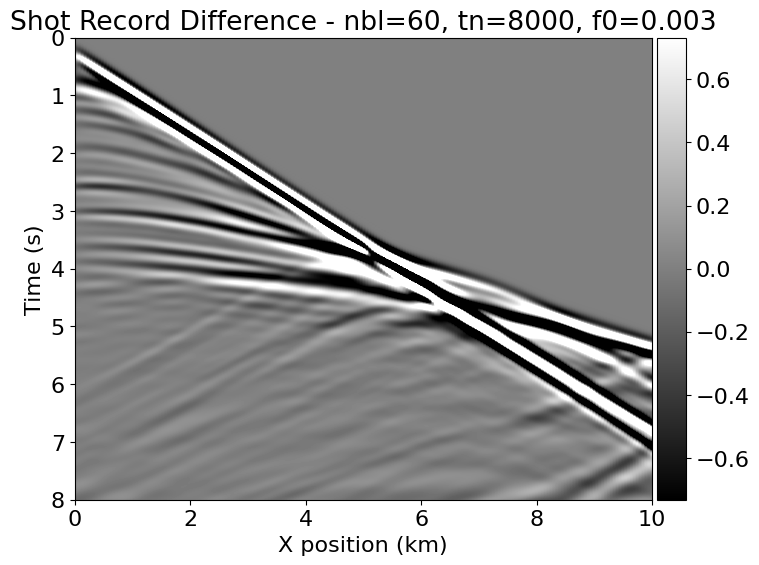

In [27]:
simple_model(tn=8000, source=0)

After we set tn to 8000ms, we see that the wave from the left source broadcast to the most right receiver around 7000ms. Then we have found a good choice for tn which is tn=8000ms. And this allows the wave to broadcast enough and also does not run too much time that cost the computation.

Apart from this, we neet to consider one more point. The wave broadcast in the way shown in the following graph:
<img src="./fig1.png">

In this way, we can calculate the distance is:

\begin{equation}
distance = \sqrt{5km^2 + 4km^2} * 2=12.8km
\tag{3}
\end{equation}

The the minimum time would be:

\begin{equation}
tn > \frac{distance}{V_{min}} = \frac{12.8km}{2km/s} = 6.4s
\tag{4}
\end{equation}

The time tn we set is 8s > 6.4s. Meet this requirement. It works!

#### Discussion - Ricker source peak frequency

Higher frequencies provide better temporal resolution, allowing the model to capture finer details of geological structures. Higher frequencies facilitate the identification of smaller geological features, but also mean the waves decay faster and may not detect structures deep underground. 

Lower frequencies enable deeper detection of geological structures. A lower frequency means a longer wavelength, capable of penetrating deeper into the formation, but with lower temporal resolution.

Let's consider what the Ricker source peak frequency f0 will influence. Consider the following equation:

\begin{equation}
\lambda = \frac{c}{f}
\tag{5}
\end{equation}

In our situation, the minimum velocity is 2000m/s. We use an initial peak frequency f0 = 0.01, which is 10Hz:

\begin{equation}
\lambda = \frac{c}{f} = \frac{2000m/s}{10Hz} = 200m
\tag{6}
\end{equation}

For a 10 Hz wave, the wavelength would be 200 meters.

The depth in our situation is 4000m, it would be better to choose a lower source peak frequency. This will provide a wavelength long enough for the wave to reach the target depth before attenuating and returning the signal from there. Then we use a smaller peak frequency f0 = 0.005, which is 5Hz:

\begin{equation}
\lambda = \frac{c}{f} = \frac{2000m/s}{5Hz} = 400m
\tag{7}
\end{equation}

The wavelength increase to 400m. This means that 5 Hz waves are able to penetrate deeper geological structures, while 10 Hz waves are better at detecting shallow structures.

Then let's put all our discussion into practice for justification.

#### Justification - Ricker source peak frequency

First, let's use a source peak frequency f0 = 0.01.

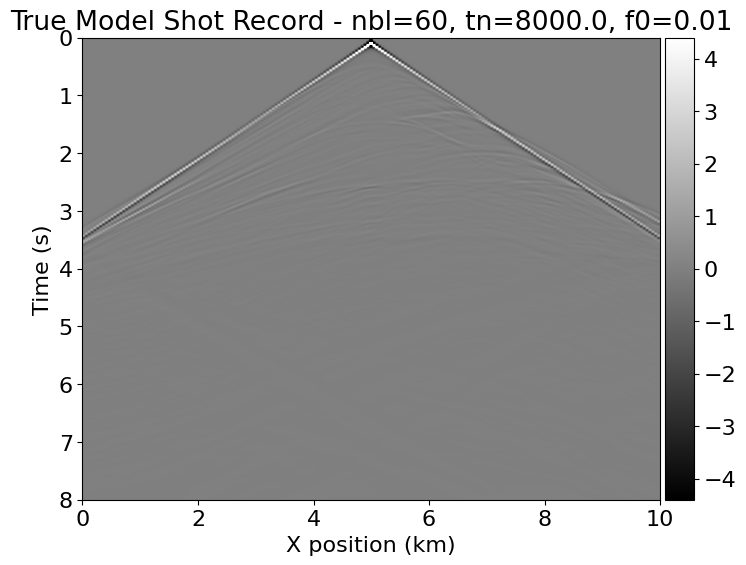

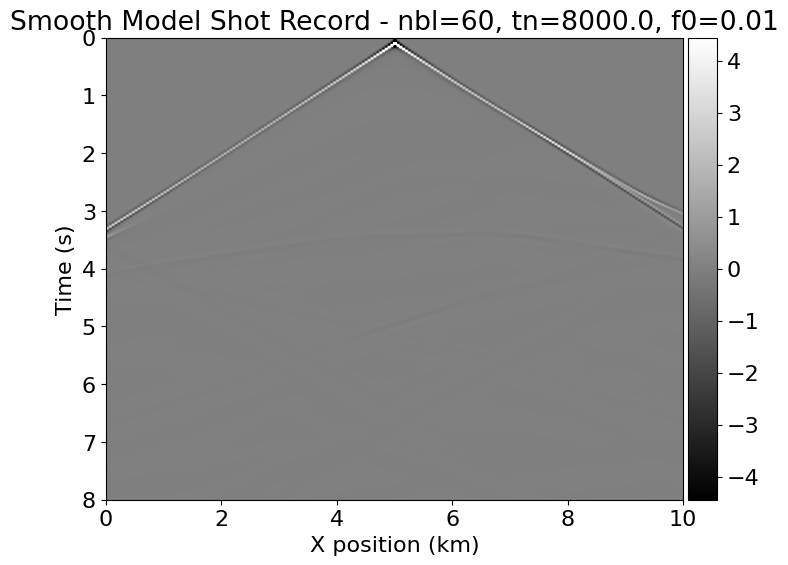

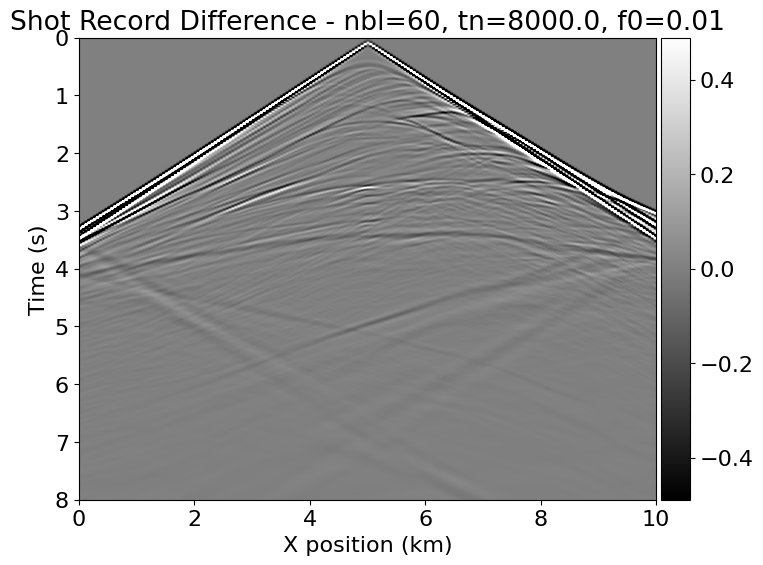

In [28]:
simple_model(f0=0.01)

Then, let's decrease the source peak frequency to 5Hz.

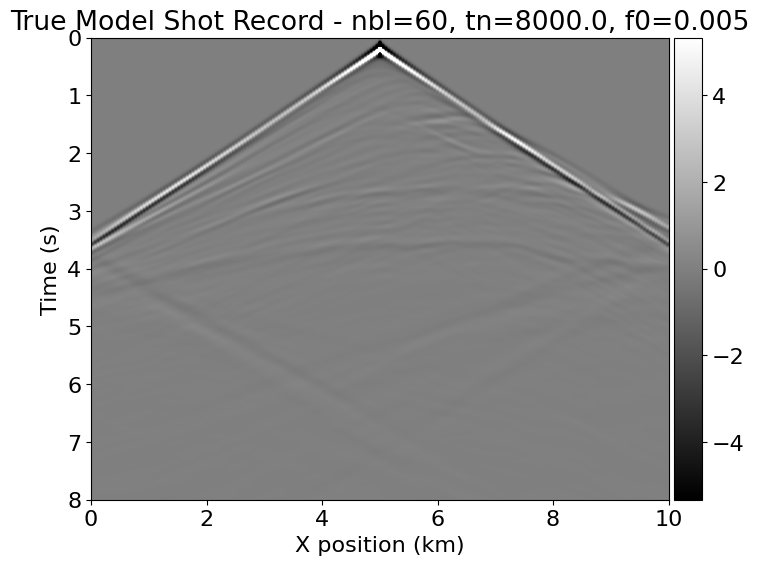

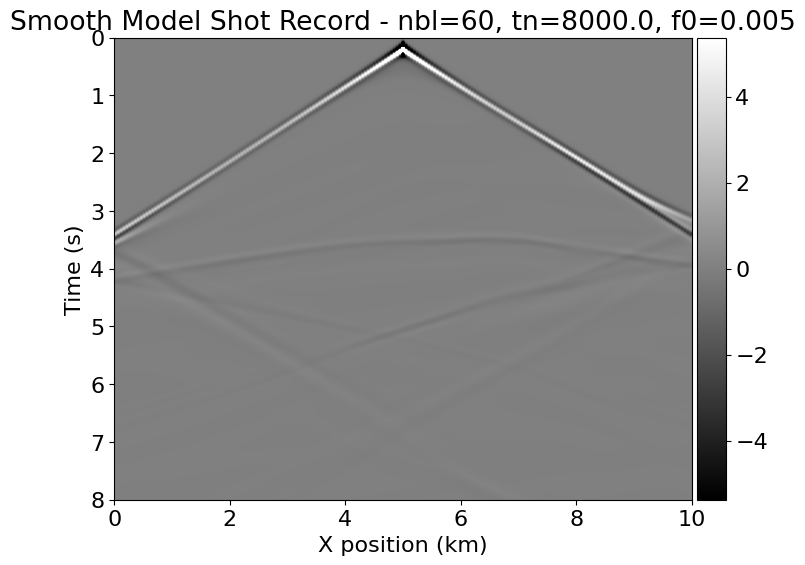

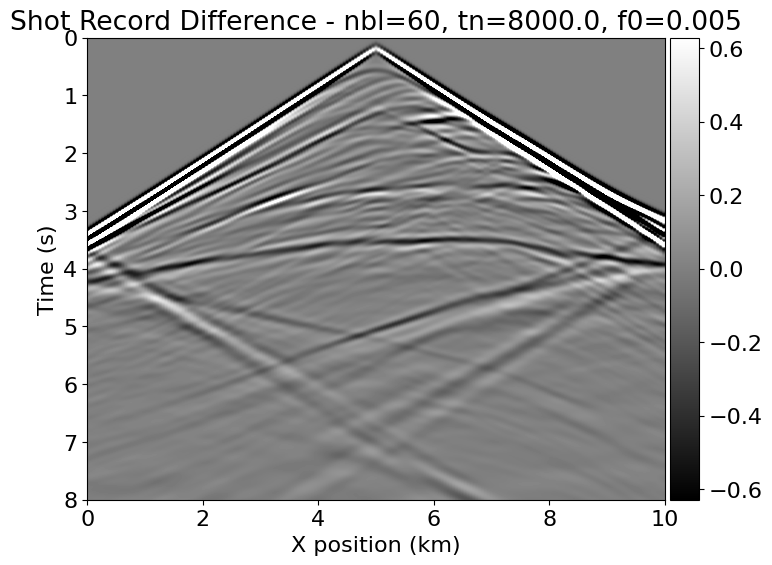

In [29]:
simple_model(f0=0.005)

Compared to f0=0.01, after we decreasing it to 0.005, we find that waveforms in the ray recording become wider and the reflection features are not as sharp as at 10 Hz, but the geological structure can be probed more deeply. A lower frequency means a longer wavelength, capable of penetrating deeper into the formation, but with lower temporal resolution.

Then we continue decreasing f0 to 0.03:

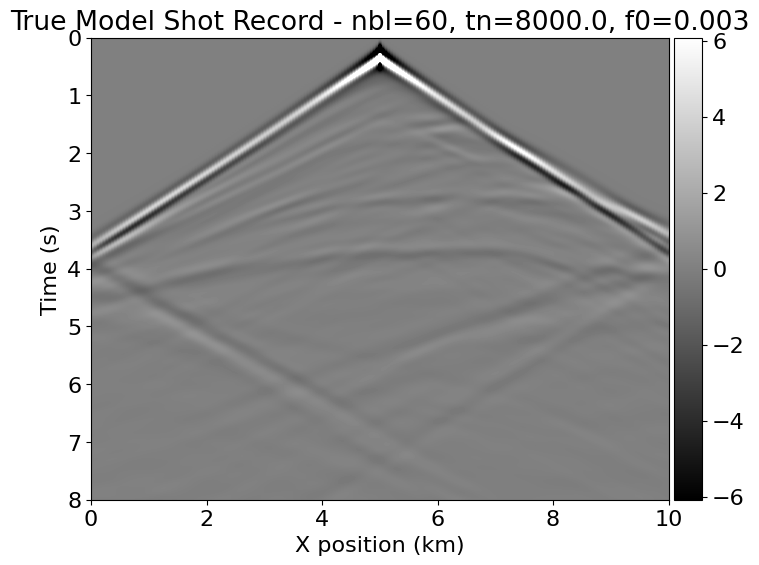

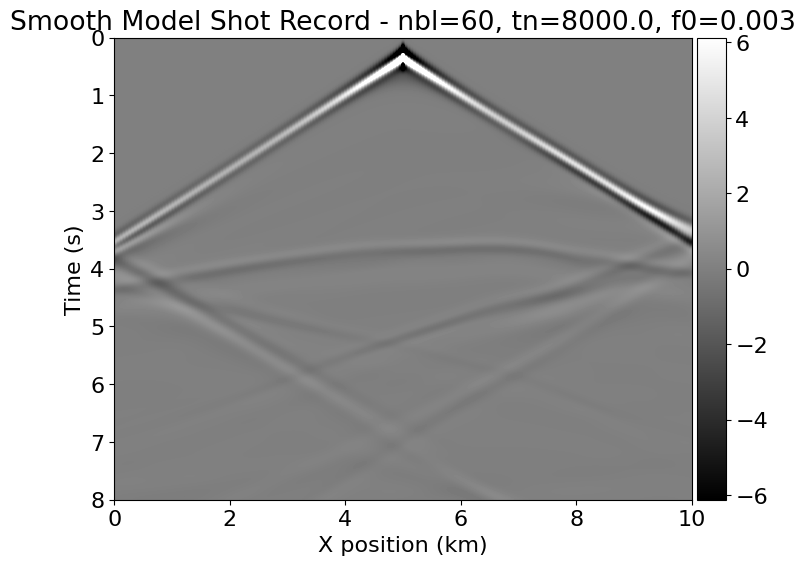

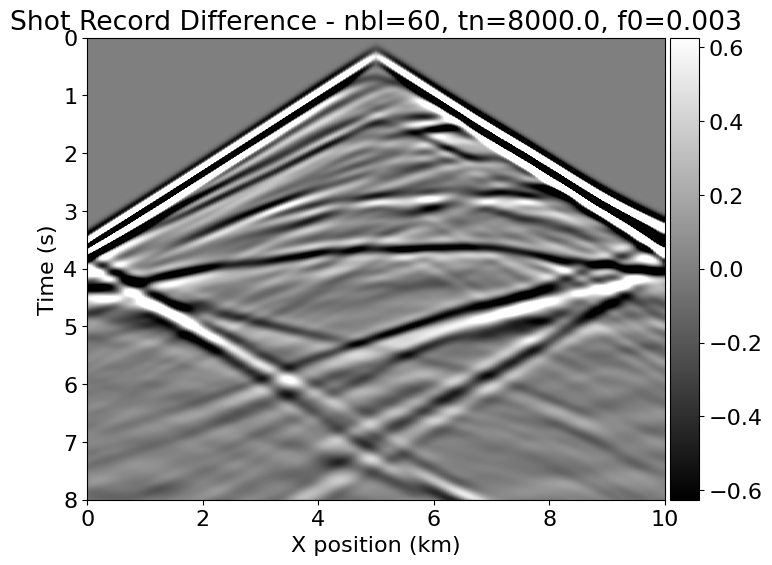

In [30]:
simple_model(f0=0.003)

We find that the waveforms in the ray recording keep becoming wider and the reflection features are not as sharp as at 5 Hz, but the geological structure can be probed more deeply.

Then we continue decreasing f0 to 0.001

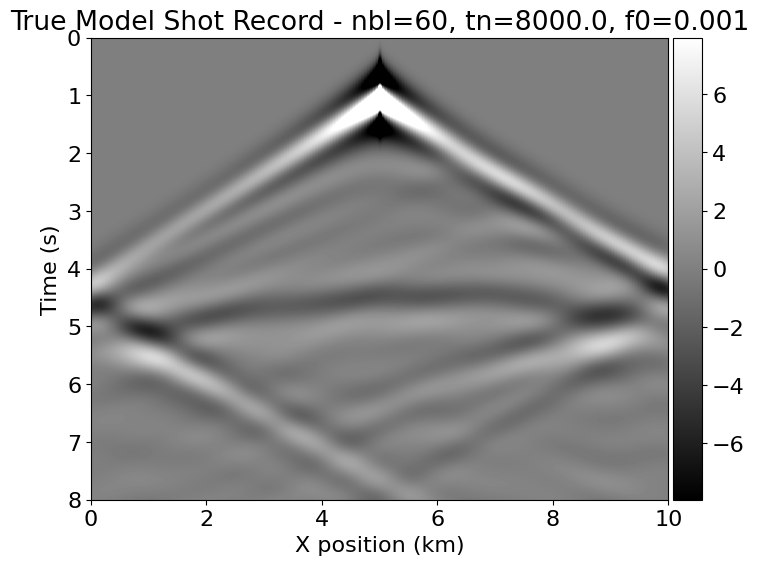

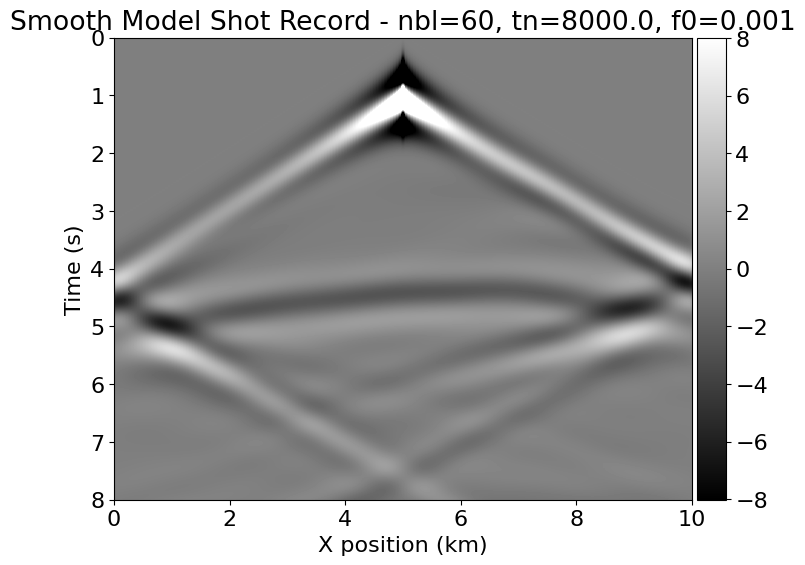

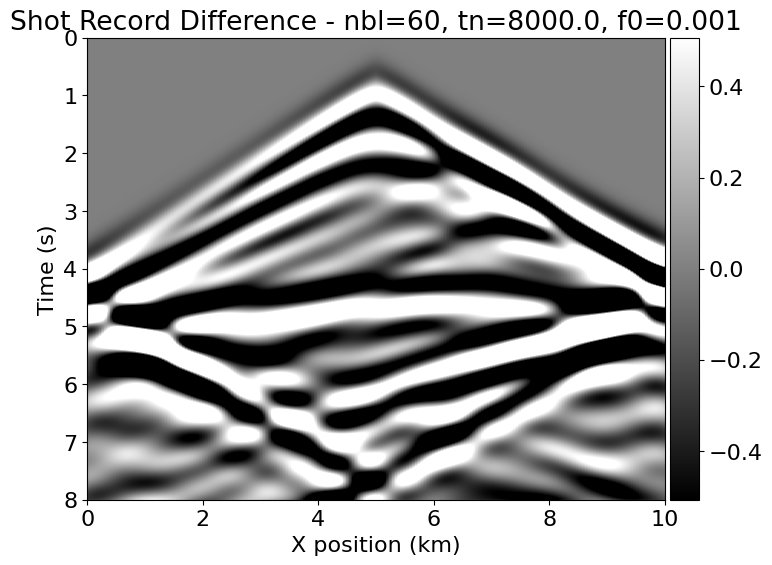

In [31]:
simple_model(f0=0.001)

Although continuously reducing f0 can detect deeper, the image begins to gradually become blurry here, which means that it cannot be detected clearly, and we cannot continue to reduce f0. Therefore, based on the above considerations, we choose f0=0.003 as our final source peak frequency.

### 4.3 Explain the positioning of the sources and receivers.

#### Discussion

The placement of sources and receivers determines the coverage and quality of wavefield data. Reasonable arrangement can ensure that underground geological structures are effectively illuminated and sufficient information can be recorded for subsequent data processing and interpretation.



The _location of source_ should be based on the following considerations:

1. Coverage: The seismic sources should be evenly distributed within the detection area to ensure that the wave field covers the entire geological structure and illuminates subsurface features from different angles.

2. Energy Penetration Depth: The source is usually located close to the surface so that the energy can penetrate downward and reach the target depth. However, the depth of the seismic source can also be adjusted based on the target characteristics.

3. Geometric arrangement: In some cases, seismic sources are arranged into specific geometric shapes, epending on the shape and size of the exploration target. This is mentioned in the lecture but will not be considered in this situation.

4. Relative position to the receiver: The source should be arranged in conjunction with the receiver to capture different types of waves such as direct waves, reflected waves, and refracted waves.


The _location of the receiver_ should consider the following factors:

1. Recording wave fields: Receivers should be evenly spaced to record the propagation of waves emanating from the source through underground structures. Uniform distribution helps to obtain high-quality seismic records that can reflect changes in the underground medium.

2. Capture reflections and refractions: Receivers need to be positioned to capture reflected and refracted waves from deep and complex structures. This usually means laying along the ground surface or a horizontal line.

3. Density and resolution: The density of the receiver should be sufficient to resolve the geological structures in the subsurface. Higher density helps improve resolution, but also increases data processing complexity.


#### Justfication

In this project, the location of the source and receiver should be reasonably selected based on the above factors:

Sources should be evenly distributed throughout the survey area, while receivers should be arranged in lines to fully record the wave field. Therefore we set the source to the far left, middle and right at a depth of 20m. Set the receiver evenly at a depth of 20m.

At the same time, in our project, the detection depth is very large, reaching 4000 meters. We also need to choose a low-frequency source to ensure the penetration of the waves (already discussed in the previous part). And the receiver arrangement should allow for long recording times to capture deep reflection signals.

### 4.4 Discuss the shot records generated and how/if they justify the choice of Acquisition geometry.

#### Shot Record Analysis

Observing the shot record, we can see the following characteristics:

Direct wave: The top of the shot record clearly shows the direct wave, which is the signal that reaches the receiver directly from the source.

Reflected waves: Some reflected waves can also be seen in the shot records, especially in the real model records. These reflected waves reveal the interface of the underground structure.

Differences: Shot record difference plots demonstrate wavefield differences between the real model and the smoothed model. These differences may represent subsurface velocity changes or structural complexity.

#### Justification of Acquisition geometry

Taking into account the above characteristics of shot recording, we can explain the choice of acquisition geometry as follows:

1. Seismic source distribution: The seismic sources are evenly distributed along the exploration area, which ensures that the entire underground area can be fully illuminated. Uniformly distributed seismic sources facilitate the generation of detailed velocity models because they provide multi-angle wavefield information.

2. Receiver distribution: Receivers are also evenly distributed on the surface and are designed to capture waves returning from different depths and directions. The distribution of receivers helps to record comprehensive wavefield data so that an accurate subsurface velocity model can be reconstructed during subsequent processing.

3. Distance between source and receiver: The choice of distance between source and receiver is also important because it determines the path the wave will take and the quality of the reflected signal that is captured. In my acquisition geometry, the distances is chosen to maximize the coverage area of the wavefield and ensure that even deep reflections are recorded.

4. Relationship between wave speed, frequency and wavelength: Shot records show the effect of changes in wave speed on wave propagation. Using a low frequency (f0=0.003, 3 Hz) means a longer wavelength, which facilitates deep detection. According to $\lambda = c/f$, the wavelengths are longer at lower frequencies, allowing them to penetrate deeper into the formation and record deep reflection signals.

5. Shot Travel time: The shot recording shows that the wave is still propagating at about 8 seconds. The longer travel time and lower frequency combined with the acquisition geometry ensure that even reflected signals from depth can be recorded.

In conclusion, the shot records support the selection of acquisition geometry and demonstrate that low-frequency sources and evenly distributed receiver layouts can effectively detect deep geological structures. This layout also helps distinguish direct waves, reflected waves, and other wavefield characteristics during data processing and interpretation to build an accurate subsurface velocity and structure model.